<a href="https://colab.research.google.com/github/bloodclaw2000/Dementia_OASIS_Saturdays/blob/testing/dementia%20colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Forzamos una versión de Python más nueva y clonamos el repositorio de GitHub para los archivos python

In [2]:
%cd /content/
import sys
sys.path.insert(0, '/usr/local/lib/python3.11/dist-packages/') #We need to upgrade Python Client for some reason COLAB is py 3.6

#!python -m pip install --upgrade pip
!git clone --single-branch --branch testing https://github.com/bloodclaw2000/Dementia_OASIS_Saturdays.git

%cd Dementia_OASIS_Saturdays

/content
Cloning into 'Dementia_OASIS_Saturdays'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 211 (delta 8), reused 53 (delta 6), pack-reused 146
Receiving objects: 100% (211/211), 560.09 MiB | 23.50 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Updating files: 100% (106/106), done.
/content/Dementia_OASIS_Saturdays


Generamos las carpetas para guardar las redes neuronales, los datasets y las figuras

In [7]:
%mkdir nn
%mkdir dataset
%mkdir plots
!pip install optuna

mkdir: cannot create directory ‘nn’: File exists
mkdir: cannot create directory ‘dataset’: File exists
mkdir: cannot create directory ‘plots’: File exists
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.4 MB/s eta 0:00:00


Importamos las librerias

In [8]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import sys
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import pickle
import _pickle as cPickle
import bz2
import csv
import torch
import torchvision
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import random
from torchvision import transforms
from tabulate import tabulate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
# from sklearn.tree import export_graphviz
from IPython.display import Image
# import graphviz
from sklearn import tree


Importamos las funciones necesarias desde nuestros programas python

In [18]:
from pickle_aux import pet_load, decompress_pickle, pet_save
from dementia_network_class import Dementia, train_nn, train_nn_auto, getOutput
from dementia_tree_class import train_tree,  Customtree
from hyperparameter_optimization import get_optimal_params, find_hyperparams_optuna, visualizeresults


**Version 1.9.1 of Project
28/05/2024**


Usamos CPU o GPU dependiendo de lo que haya

In [19]:
torch.multiprocessing.set_start_method('spawn', force=True) #kinda important mostly for CPU

device = torch.device(
                                        f'cuda:{torch.cuda.current_device()}'
                                        if torch.cuda.is_available()
                                        else 'cpu')

In [20]:
def createnecessaryfolders():
    if not os.path.exists(f"plots/"):
        os.makedirs(f"plots/")
    if not os.path.exists(f"studies/"):
        os.makedirs(f"studies/")
    if not os.path.exists(f"params_nn/"):
        os.makedirs(f"params_nn/")
    if not os.path.exists(f"nn/"):
        os.makedirs(f"nn/")
    if not os.path.exists(f"logs/"):
        os.makedirs(f"logs/")
    if not os.path.exists(f"hyperparams/"):
        os.makedirs(f"hyperparams/")
    if not os.path.exists(f"dataset/"):
        os.makedirs(f"dataset/")
    if not os.path.exists(f"params_tree/"):
        os.makedirs(f"params_tree/")


Cargamos el diccionario y generamos uno nuevo limpio sin comprimir

In [21]:
compressed_pickle_directory = "save_dict3"
if not os.path.exists('{0}_decompressed.p'.format(compressed_pickle_directory)):
    def force_dementia(dictionary):
              for key in dictionary:
                        for key2 in dictionary[key]:
                            if dictionary[key][key2]['CDR'] == '':
                                      dictionary[key][key2]['Dementia'] = 0
                            elif float(dictionary[key][key2]['CDR']) > 0:
                                      dictionary[key][key2]['Dementia'] = 1
                            else:
                                      dictionary[key][key2]['Dementia'] = 0
              return dictionary

    def removeyoung(dictionary, age):
              dic_pacientes_viejos = {}
              for key in dictionary:
                        for key2 in dictionary[key]:
                            if int(dictionary[key][key2]['Age']) >= age:
                                      dic_pacientes_viejos[key] = dictionary[key]
              return dic_pacientes_viejos

    tmp_dict = decompress_pickle('{0}.pbz2'.format(compressed_pickle_directory))
    tmp_dict = force_dementia(tmp_dict) #esto es la funcion del init
    tmp_dict = removeyoung(tmp_dict, 59)
    tmp_dict = {int(key): value for key, value in tmp_dict.items()}
    new_dict = {}
    current_index = 0
    for key in sorted(tmp_dict.keys()):
                        new_dict[current_index] = tmp_dict[key]
                        current_index += 1
    tmp_dict = new_dict

    pet_save(tmp_dict,'{0}_decompressed.p'.format(compressed_pickle_directory))
else:
     tmp_dict=pet_load('{0}_decompressed.p'.format(compressed_pickle_directory))


Forzamos el device y generamos un objeto de todas las redes neuronales

In [22]:
torch.set_default_device(device)

print(device)

print(f" Using {device} in this run")

logpath = 'logs/'
createnecessaryfolders()
obj = Dementia(dictionary=tmp_dict, device=device)


cuda:0
 Using cuda:0 in this run
134192926


Seteamos los parámetros manualmente que queramos, también hay archivos txt en params

In [23]:
#Podemos setear los parámetros para el entrenamiento aquí:
obj.setParam('image_type','T88_111')
obj.setParam('image_number',1)


In [24]:
parameter_ranges = {
    'patience_validation': [3],
    'patience_plateau': [3],
    'delta_min': [0, 0.001, 0.01, 0.1],
    'batch_size': [10, 20, 30, 40, 50],
    'split_size': [0.7, 0.8, 0.9],
    'max_loss_reset': [1, 3, 5, 7, 10],
    'learning_rate': [0.0001, 0.0001, 0.00001],
    'weight_decay': [0.1, 0.01, 0.1, 0.2],
    'first_conv_outchann': [6, 8, 12],
    'second_conv_outchann': [16, 20, 24],
    'fclayer1': [120, 150, 200],
    'fclayer2': ['None', 100, 150],
    'optimizer': ['Adam', 'SGD']
}


Entrenamos la optimizacion de hiperparametros así

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:236: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage_name = JournalStorage(JournalFileStorage(logname, lock_obj = lock_obj))
[I 2024-06-04 17:24:40,680] Using an existing study with name 'RAW_1_hyperparameter_study' instead of creating a new one.


hyper_RAW_1.txt
RAW_1.txt
Read parameters dictionary at relative location params_nn/RAW_1.txt and setting them 
Read parameters dictionary at relative location params_nn/RAW_1.txt and setting them 
{'delta_min': (0, 0.1, 1, 'log'), 'batch_size': (10, 50, 10, None), 'split_size': (0.7, 0.8, 0.05, None), 'max_loss_reset': (1, 9, 2, None), 'learning_rate': (1e-05, 0.001, 1, 'log'), 'weight_decay': (0.01, 0.1, 1, 'log'), 'first_conv_outchann': (6, 12, 2, None), 'second_conv_outchann': (16, 24, 4, None), 'fclayer1': (120, 210, 30, None), 'fclayer2': (0, 150, 30, None)}
Read parameters dictionary at relative location params_nn/RAW_1.txt and setting them 
{'plot': 'True', 'image_type': 'RAW', 'image_number': 1, 'patience_validation': 3, 'patience_plateau': 3, 'validation_patience': 3, 'delta_min': '0', 'batch_size': 10, 'split_size': 0.75, 'max_loss_reset': 5, 'learning_rate': 2.0002206500256113e-05, 'weight_decay': 0.0499393257842935, 'nepochs': 100, 'first_conv_outchann': 12, 'second_conv_o

[I 2024-06-04 17:25:08,324] Trial 2 finished with value: 0.009318978246301412 and parameters: {'delta_min': '0', 'batch_size': 10, 'split_size': 0.75, 'max_loss_reset': 5, 'learning_rate': 2.0002206500256113e-05, 'weight_decay': 0.0499393257842935, 'first_conv_outchann': 12, 'second_conv_outchann': 24, 'fclayer1': 150, 'fclayer2': 120}. Best is trial 2 with value: 0.009318978246301412.


Finished Training in 27 epochs
Accuracy: 0.5526315789473685
Precision: 0.5294117647058824
Recall: 0.5
1-score: 0.5142857142857143
Average Loss: 1.1411876302016408
Read parameters dictionary at relative location params_nn/RAW_1.txt and setting them 
{'plot': 'True', 'image_type': 'RAW', 'image_number': 1, 'patience_validation': 3, 'patience_plateau': 3, 'validation_patience': 3, 'delta_min': '0', 'batch_size': 30, 'split_size': 0.7999999999999999, 'max_loss_reset': 1, 'learning_rate': 1.9220404477600057e-05, 'weight_decay': 0.03429718373195235, 'nepochs': 100, 'first_conv_outchann': 6, 'second_conv_outchann': 24, 'fclayer1': 120, 'fclayer2': 0, 'criterion_type': 'BCElogitsloss', 'optimizer': 'Adam', 'verbosity': 1}


[I 2024-06-04 17:25:56,949] Trial 3 finished with value: 0.005814172700047493 and parameters: {'delta_min': '0', 'batch_size': 30, 'split_size': 0.7999999999999999, 'max_loss_reset': 1, 'learning_rate': 1.9220404477600057e-05, 'weight_decay': 0.03429718373195235, 'first_conv_outchann': 6, 'second_conv_outchann': 24, 'fclayer1': 120, 'fclayer2': 0}. Best is trial 3 with value: 0.005814172700047493.


Finished Training in 59 epochs
Accuracy: 0.5333333333333333
Precision: 0.5
Recall: 0.42857142857142855
1-score: 0.4615384615384615
Average Loss: 0.9651951789855957
Read parameters dictionary at relative location params_nn/RAW_1.txt and setting them 
{'plot': 'True', 'image_type': 'RAW', 'image_number': 1, 'patience_validation': 3, 'patience_plateau': 3, 'validation_patience': 3, 'delta_min': '0.1', 'batch_size': 40, 'split_size': 0.7, 'max_loss_reset': 3, 'learning_rate': 0.0009492235942399399, 'weight_decay': 0.018558639393479667, 'nepochs': 100, 'first_conv_outchann': 10, 'second_conv_outchann': 24, 'fclayer1': 120, 'fclayer2': 60, 'criterion_type': 'BCElogitsloss', 'optimizer': 'Adam', 'verbosity': 1}


[I 2024-06-04 17:26:10,210] Trial 4 finished with value: 0.06932334154844284 and parameters: {'delta_min': '0.1', 'batch_size': 40, 'split_size': 0.7, 'max_loss_reset': 3, 'learning_rate': 0.0009492235942399399, 'weight_decay': 0.018558639393479667, 'first_conv_outchann': 10, 'second_conv_outchann': 24, 'fclayer1': 120, 'fclayer2': 60}. Best is trial 3 with value: 0.005814172700047493.


Finished Training in 17 epochs
Accuracy: 0.4666666666666667
Precision: 0.4666666666666667
Recall: 1.0
1-score: 0.6363636363636364
Average Loss: 0.6946205231878493
Read parameters dictionary at relative location params_nn/RAW_1.txt and setting them 
{'plot': 'True', 'image_type': 'RAW', 'image_number': 1, 'patience_validation': 3, 'patience_plateau': 3, 'validation_patience': 3, 'delta_min': '0', 'batch_size': 40, 'split_size': 0.7999999999999999, 'max_loss_reset': 1, 'learning_rate': 0.00021592450561341403, 'weight_decay': 0.028713682951316717, 'nepochs': 100, 'first_conv_outchann': 6, 'second_conv_outchann': 20, 'fclayer1': 180, 'fclayer2': 30, 'criterion_type': 'BCElogitsloss', 'optimizer': 'Adam', 'verbosity': 1}


[I 2024-06-04 17:27:33,111] Trial 5 finished with value: 0.08647474348545074 and parameters: {'delta_min': '0', 'batch_size': 40, 'split_size': 0.7999999999999999, 'max_loss_reset': 1, 'learning_rate': 0.00021592450561341403, 'weight_decay': 0.028713682951316717, 'first_conv_outchann': 6, 'second_conv_outchann': 20, 'fclayer1': 180, 'fclayer2': 30}. Best is trial 3 with value: 0.005814172700047493.


Finished Training in 99 epochs
Accuracy: 0.4
Precision: 0.3333333333333333
Recall: 0.2857142857142857
1-score: 0.30769230769230765
Average Loss: 0.6943750381469727
Read parameters dictionary at relative location params_nn/RAW_1.txt and setting them 
{'plot': 'True', 'image_type': 'RAW', 'image_number': 1, 'patience_validation': 3, 'patience_plateau': 3, 'validation_patience': 3, 'delta_min': '0.1', 'batch_size': 30, 'split_size': 0.7, 'max_loss_reset': 3, 'learning_rate': 0.0005245367514635877, 'weight_decay': 0.08499216269950781, 'nepochs': 100, 'first_conv_outchann': 10, 'second_conv_outchann': 16, 'fclayer1': 150, 'fclayer2': 30, 'criterion_type': 'BCElogitsloss', 'optimizer': 'Adam', 'verbosity': 1}


[I 2024-06-04 17:27:50,302] Trial 6 finished with value: 0.00046872320817783477 and parameters: {'delta_min': '0.1', 'batch_size': 30, 'split_size': 0.7, 'max_loss_reset': 3, 'learning_rate': 0.0005245367514635877, 'weight_decay': 0.08499216269950781, 'first_conv_outchann': 10, 'second_conv_outchann': 16, 'fclayer1': 150, 'fclayer2': 30}. Best is trial 6 with value: 0.00046872320817783477.


Finished Training in 21 epochs
Accuracy: 0.4888888888888889
Precision: 0.4444444444444444
Recall: 0.38095238095238093
1-score: 0.41025641025641024
Average Loss: 1.1847720596525404
Read parameters dictionary at relative location params_nn/RAW_1.txt and setting them 
{'plot': 'True', 'image_type': 'RAW', 'image_number': 1, 'patience_validation': 3, 'patience_plateau': 3, 'validation_patience': 3, 'delta_min': '0', 'batch_size': 30, 'split_size': 0.7999999999999999, 'max_loss_reset': 7, 'learning_rate': 0.00027265733529765584, 'weight_decay': 0.07546889298343618, 'nepochs': 100, 'first_conv_outchann': 10, 'second_conv_outchann': 16, 'fclayer1': 180, 'fclayer2': 0, 'criterion_type': 'BCElogitsloss', 'optimizer': 'Adam', 'verbosity': 1}


[I 2024-06-04 17:28:02,081] Trial 7 finished with value: 0.06178212761878967 and parameters: {'delta_min': '0', 'batch_size': 30, 'split_size': 0.7999999999999999, 'max_loss_reset': 7, 'learning_rate': 0.00027265733529765584, 'weight_decay': 0.07546889298343618, 'first_conv_outchann': 10, 'second_conv_outchann': 16, 'fclayer1': 180, 'fclayer2': 0}. Best is trial 6 with value: 0.00046872320817783477.


Finished Training in 13 epochs
Accuracy: 0.5333333333333333
Precision: 0.5
Recall: 0.7857142857142857
1-score: 0.6111111111111112
Average Loss: 0.7412440180778503
Read parameters dictionary at relative location params_nn/RAW_1.txt and setting them 
{'plot': 'True', 'image_type': 'RAW', 'image_number': 1, 'patience_validation': 3, 'patience_plateau': 3, 'validation_patience': 3, 'delta_min': '0', 'batch_size': 30, 'split_size': 0.75, 'max_loss_reset': 9, 'learning_rate': 0.00010777693033555087, 'weight_decay': 0.015345081872306451, 'nepochs': 100, 'first_conv_outchann': 10, 'second_conv_outchann': 24, 'fclayer1': 210, 'fclayer2': 150, 'criterion_type': 'BCElogitsloss', 'optimizer': 'Adam', 'verbosity': 1}


[I 2024-06-04 17:28:17,748] Trial 8 finished with value: 0.07356214125951131 and parameters: {'delta_min': '0', 'batch_size': 30, 'split_size': 0.75, 'max_loss_reset': 9, 'learning_rate': 0.00010777693033555087, 'weight_decay': 0.015345081872306451, 'first_conv_outchann': 10, 'second_conv_outchann': 24, 'fclayer1': 210, 'fclayer2': 150}. Best is trial 6 with value: 0.00046872320817783477.


Finished Training in 19 epochs
Accuracy: 0.47368421052631576
Precision: 0.47368421052631576
Recall: 1.0
1-score: 0.6428571428571429
Average Loss: 0.7664323260909632
Read parameters dictionary at relative location params_nn/RAW_1.txt and setting them 
{'plot': 'True', 'image_type': 'RAW', 'image_number': 1, 'patience_validation': 3, 'patience_plateau': 3, 'validation_patience': 3, 'delta_min': '0.1', 'batch_size': 30, 'split_size': 0.75, 'max_loss_reset': 7, 'learning_rate': 0.00015166832876972213, 'weight_decay': 0.030165478953837296, 'nepochs': 100, 'first_conv_outchann': 6, 'second_conv_outchann': 24, 'fclayer1': 180, 'fclayer2': 0, 'criterion_type': 'BCElogitsloss', 'optimizer': 'Adam', 'verbosity': 1}


[I 2024-06-04 17:28:34,873] Trial 9 finished with value: 0.1278657615184784 and parameters: {'delta_min': '0.1', 'batch_size': 30, 'split_size': 0.75, 'max_loss_reset': 7, 'learning_rate': 0.00015166832876972213, 'weight_decay': 0.030165478953837296, 'first_conv_outchann': 6, 'second_conv_outchann': 24, 'fclayer1': 180, 'fclayer2': 0}. Best is trial 6 with value: 0.00046872320817783477.


Finished Training in 21 epochs
Accuracy: 0.5263157894736842
Precision: 0.5
Recall: 0.5555555555555556
1-score: 0.5263157894736842
Average Loss: 0.6910511349376879
Read parameters dictionary at relative location params_nn/RAW_1.txt and setting them 
{'plot': 'True', 'image_type': 'RAW', 'image_number': 1, 'patience_validation': 3, 'patience_plateau': 3, 'validation_patience': 3, 'delta_min': '0.1', 'batch_size': 50, 'split_size': 0.7, 'max_loss_reset': 3, 'learning_rate': 0.0008558086994712576, 'weight_decay': 0.09613906048029029, 'nepochs': 100, 'first_conv_outchann': 12, 'second_conv_outchann': 20, 'fclayer1': 150, 'fclayer2': 120, 'criterion_type': 'BCElogitsloss', 'optimizer': 'Adam', 'verbosity': 1}


[I 2024-06-04 17:28:49,491] Trial 10 finished with value: 0.0327815055847168 and parameters: {'delta_min': '0.1', 'batch_size': 50, 'split_size': 0.7, 'max_loss_reset': 3, 'learning_rate': 0.0008558086994712576, 'weight_decay': 0.09613906048029029, 'first_conv_outchann': 12, 'second_conv_outchann': 20, 'fclayer1': 150, 'fclayer2': 120}. Best is trial 6 with value: 0.00046872320817783477.


Finished Training in 18 epochs
Accuracy: 0.5555555555555556
Precision: 0.5185185185185185
Recall: 0.6666666666666666
1-score: 0.5833333333333334
Average Loss: 0.6958757546212938
Read parameters dictionary at relative location params_nn/RAW_1.txt and setting them 
{'plot': 'True', 'image_type': 'RAW', 'image_number': 1, 'patience_validation': 3, 'patience_plateau': 3, 'validation_patience': 3, 'delta_min': '0.1', 'batch_size': 20, 'split_size': 0.7, 'max_loss_reset': 1, 'learning_rate': 1.0446399755790698e-05, 'weight_decay': 0.057312098754893785, 'nepochs': 100, 'first_conv_outchann': 8, 'second_conv_outchann': 16, 'fclayer1': 120, 'fclayer2': 60, 'criterion_type': 'BCElogitsloss', 'optimizer': 'Adam', 'verbosity': 1}


[I 2024-06-04 17:30:07,824] Trial 11 finished with value: 0.7764189047353284 and parameters: {'delta_min': '0.1', 'batch_size': 20, 'split_size': 0.7, 'max_loss_reset': 1, 'learning_rate': 1.0446399755790698e-05, 'weight_decay': 0.057312098754893785, 'first_conv_outchann': 8, 'second_conv_outchann': 16, 'fclayer1': 120, 'fclayer2': 60}. Best is trial 6 with value: 0.00046872320817783477.


Finished Training in 99 epochs
Accuracy: 0.4666666666666667
Precision: 0.4666666666666667
Recall: 1.0
1-score: 0.6363636363636364
Average Loss: 2.8310004075368247
Best parameters: {'delta_min': '0.1', 'batch_size': 30, 'split_size': 0.7, 'max_loss_reset': 3, 'learning_rate': 0.0005245367514635877, 'weight_decay': 0.08499216269950781, 'first_conv_outchann': 10, 'second_conv_outchann': 16, 'fclayer1': 150, 'fclayer2': 30}
Study statistics: 
  Number of finished trials:  12
  Number of pruned trials:  0
  Number of complete trials:  12
Best Trials [FrozenTrial(number=6, state=TrialState.COMPLETE, values=[0.00046872320817783477], datetime_start=datetime.datetime(2024, 6, 4, 17, 27, 33, 118648), datetime_complete=datetime.datetime(2024, 6, 4, 17, 27, 50, 297294), params={'delta_min': '0.1', 'batch_size': 30, 'split_size': 0.7, 'max_loss_reset': 3, 'learning_rate': 0.0005245367514635877, 'weight_decay': 0.08499216269950781, 'first_conv_outchann': 10, 'second_conv_outchann': 16, 'fclayer1': 1

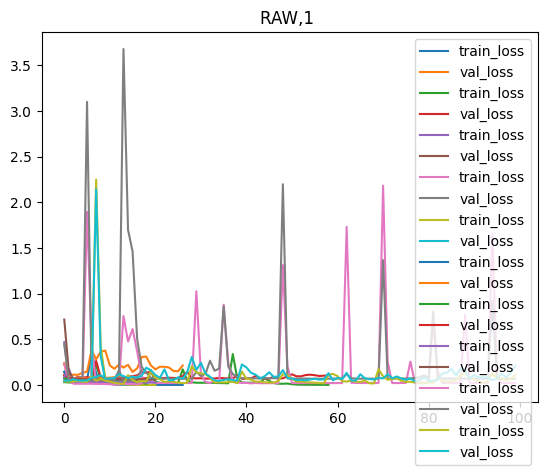

In [25]:
if os.path.exists('tmp_nn.p'):
    obj = pet_load('tmp_nn.p')
    print(f"USing old unfinished dataset split with seed {obj.seed}")
find_hyperparams_optuna(obj, 'params_nn/','hyperparams/','studies/', ['RAW_1'],logpath = logpath, n_trials= 10)


Y visualizamos los resultados de un estudio


Best trial until now:
 Value:  0.00046872320817783477
 Params: 
    delta_min: 0.1
    batch_size: 30
    split_size: 0.7
    max_loss_reset: 3
    learning_rate: 0.0005245367514635877
    weight_decay: 0.08499216269950781
    first_conv_outchann: 10
    second_conv_outchann: 16
    fclayer1: 150
    fclayer2: 30
Best parameters: {'delta_min': '0.1', 'batch_size': 30, 'split_size': 0.7, 'max_loss_reset': 3, 'learning_rate': 0.0005245367514635877, 'weight_decay': 0.08499216269950781, 'first_conv_outchann': 10, 'second_conv_outchann': 16, 'fclayer1': 150, 'fclayer2': 30}
Study statistics: 
  Number of finished trials:  12
  Number of pruned trials:  0
  Number of complete trials:  12
Best Trials [FrozenTrial(number=6, state=TrialState.COMPLETE, values=[0.00046872320817783477], datetime_start=datetime.datetime(2024, 6, 4, 17, 27, 33, 118648), datetime_complete=datetime.datetime(2024, 6, 4, 17, 27, 50, 297294), params={'delta_min': '0.1', 'batch_size': 30, 'split_size': 0.7, 'max_loss_rese

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:321: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optimization_history = optuna.visualization.matplotlib.plot_optimization_history(study)


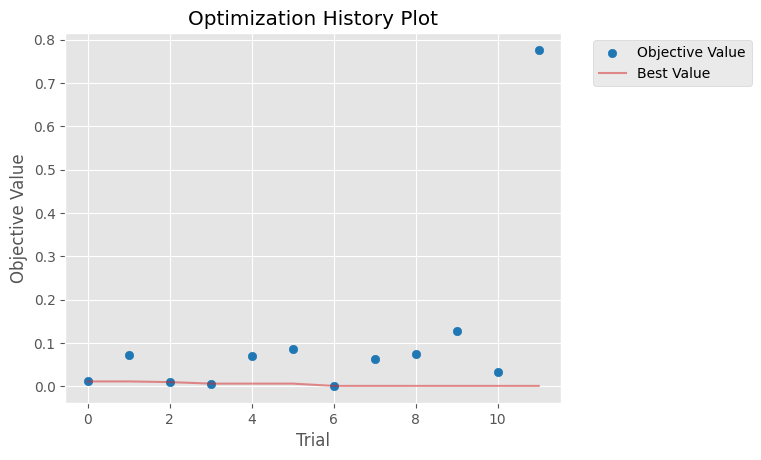

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:325: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  param_importances =  optuna.visualization.matplotlib.plot_param_importances(study)


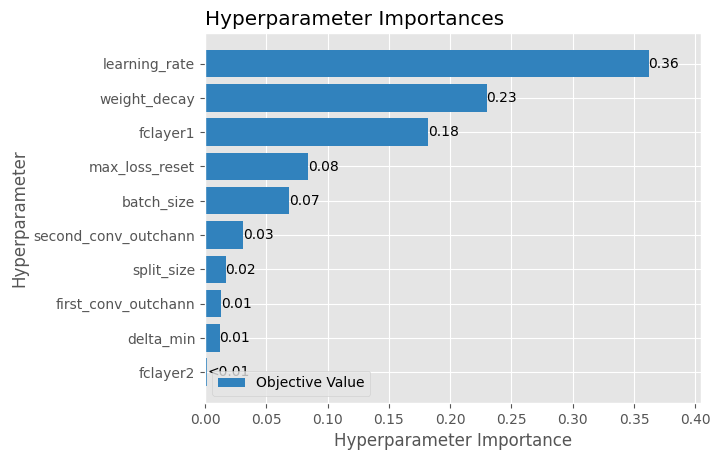

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:330: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  parallel_coordinate =  optuna.visualization.matplotlib.plot_parallel_coordinate(study)


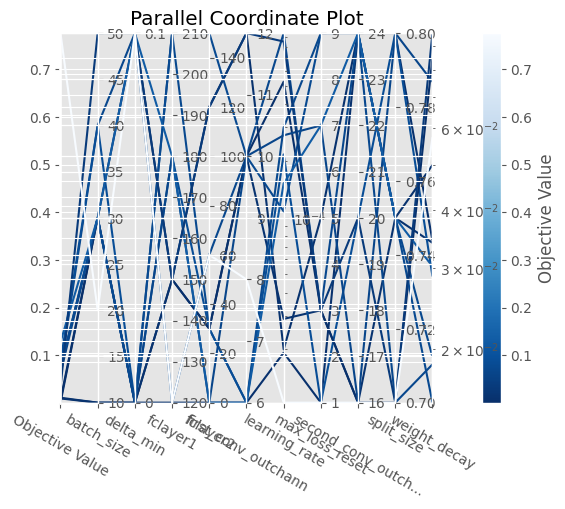

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:335: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  slice_plot =  optuna.visualization.matplotlib.plot_slice(study)


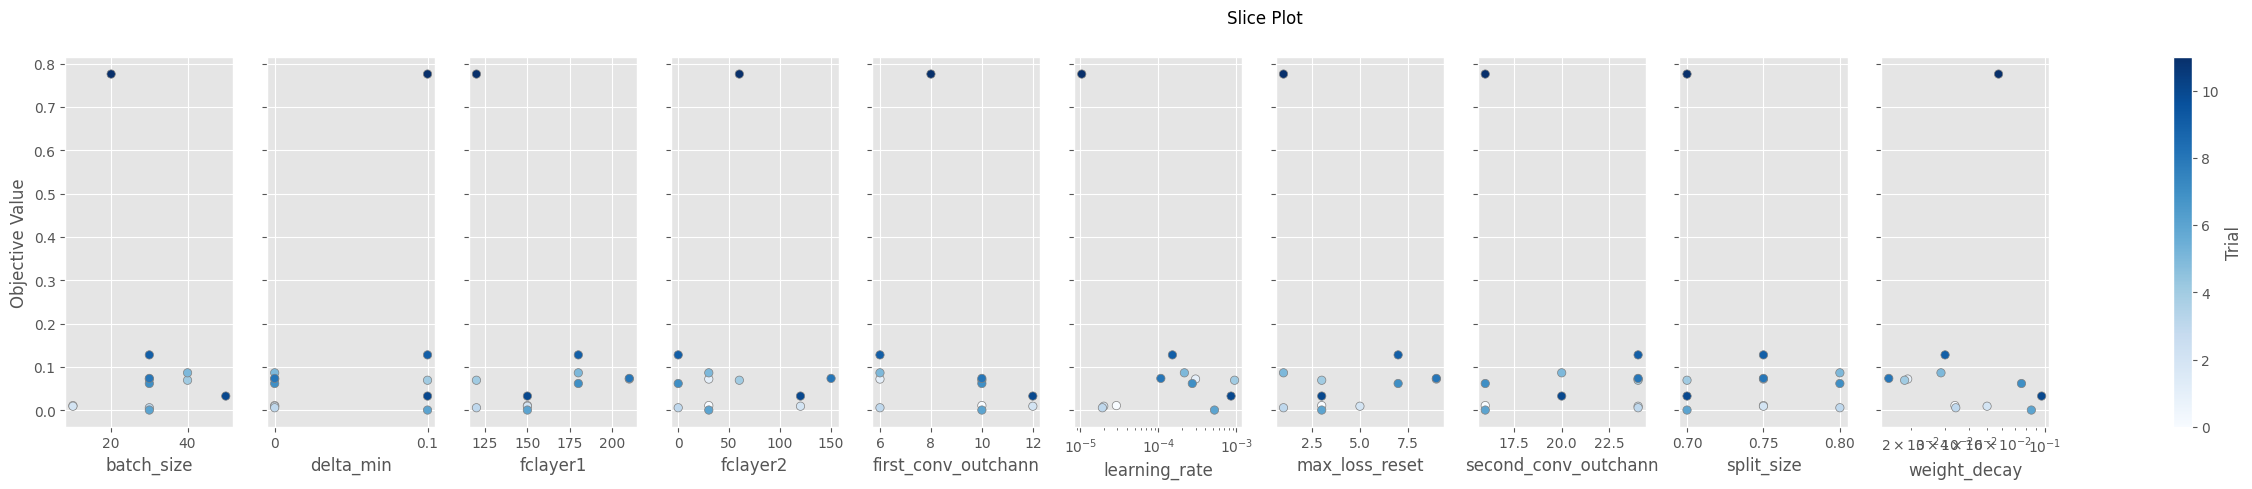

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:15,245] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


10


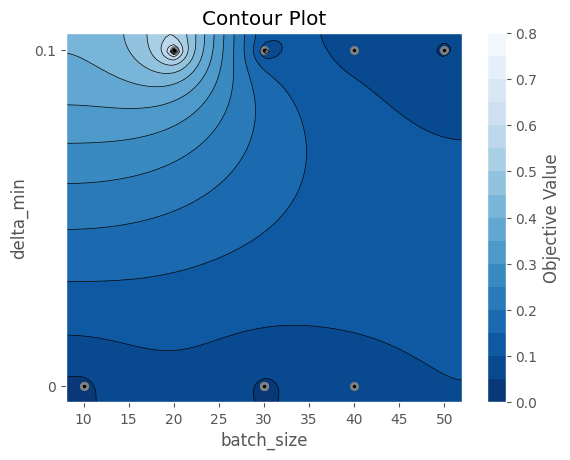

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:16,114] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


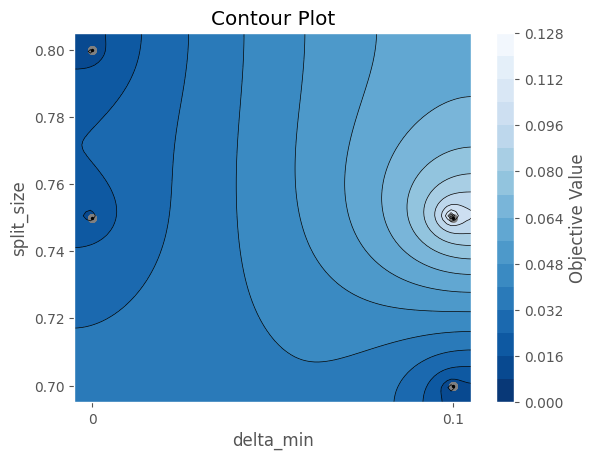

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:16,774] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


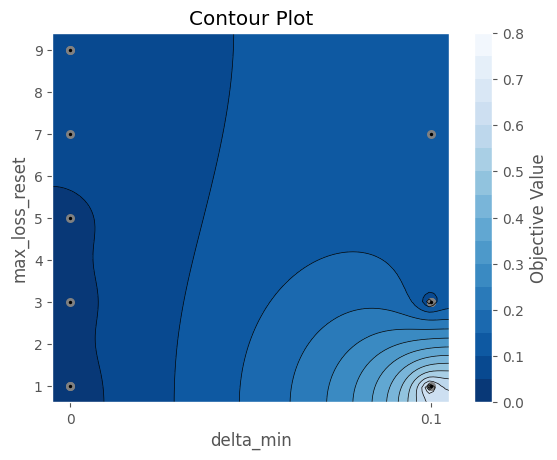

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:17,394] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


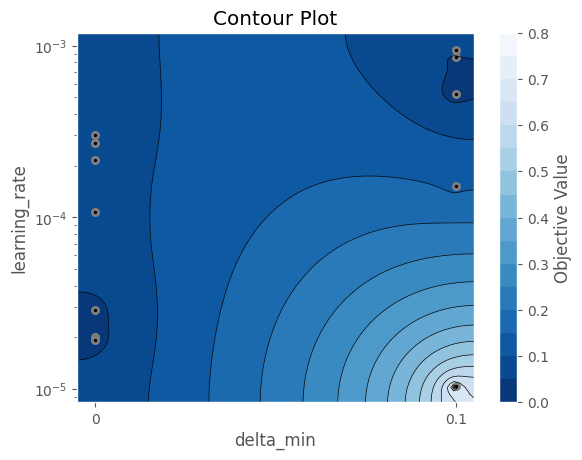

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:18,280] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


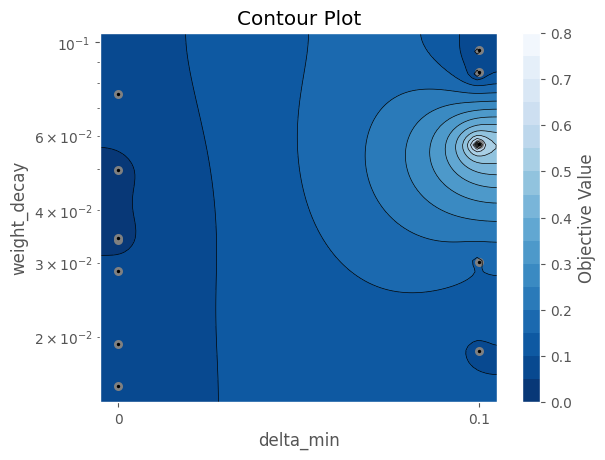

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:19,129] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


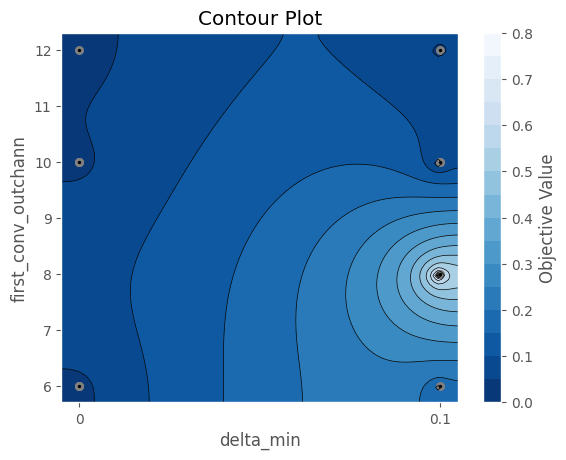

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:19,726] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


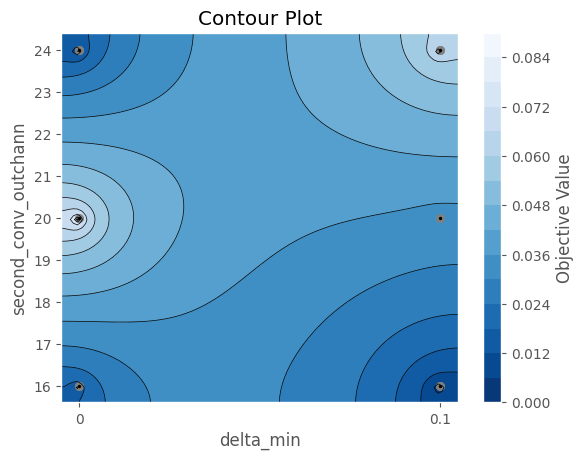

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:20,339] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


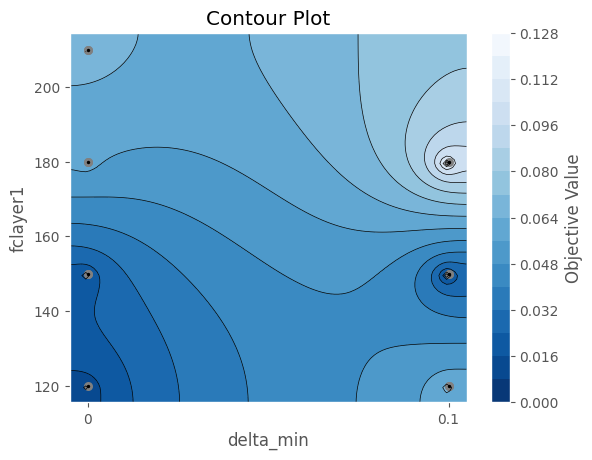

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:20,962] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


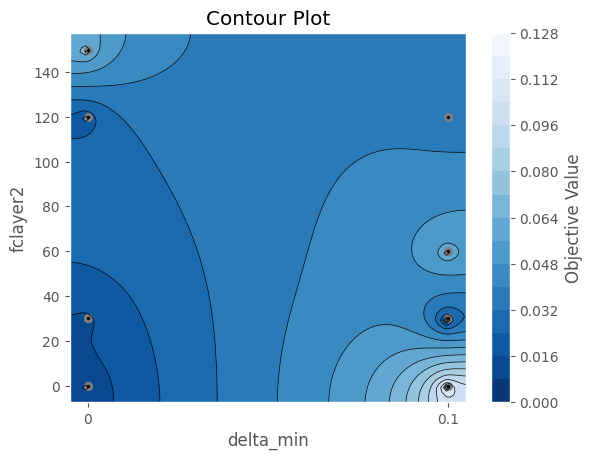

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:21,832] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


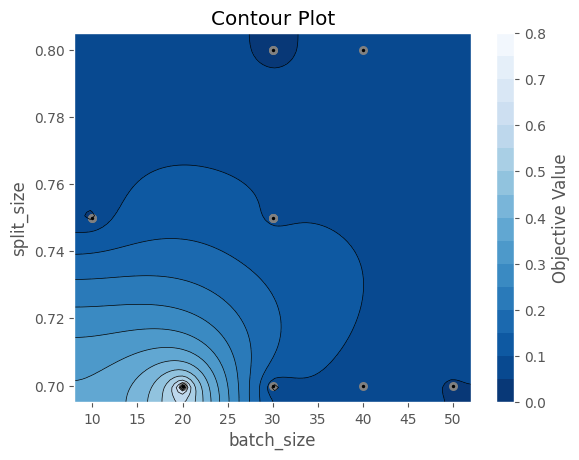

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:22,547] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


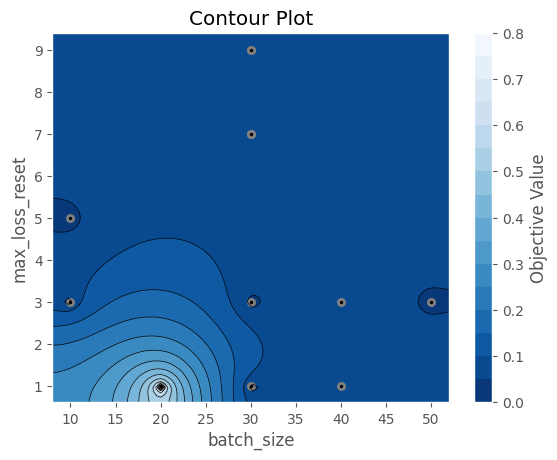

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:23,283] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


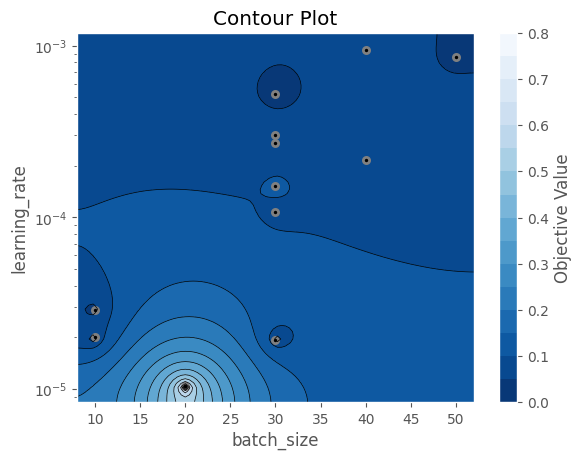

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:24,245] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


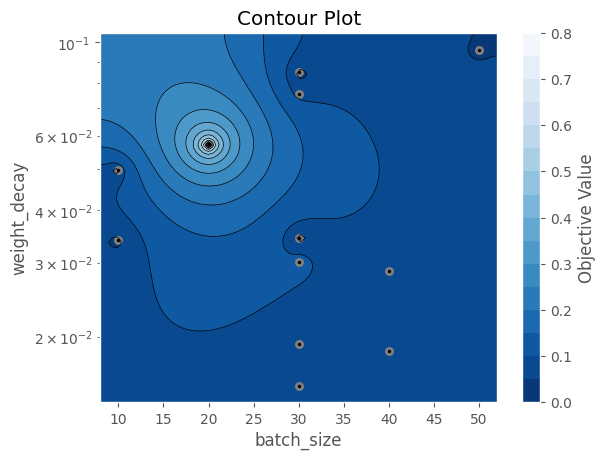

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:25,191] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


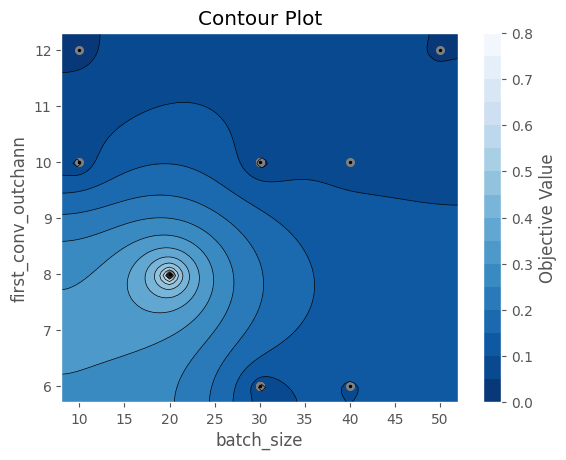

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:25,915] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


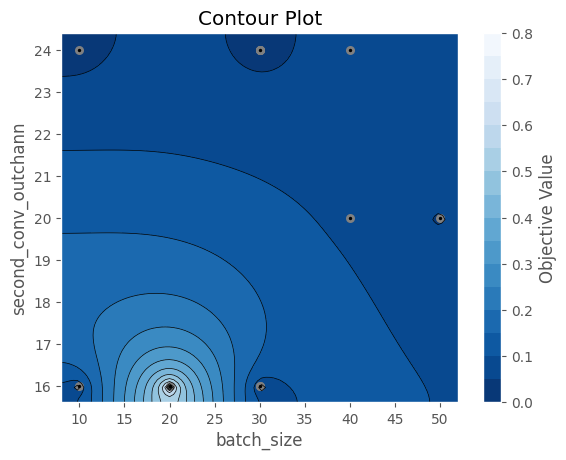

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:27,032] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


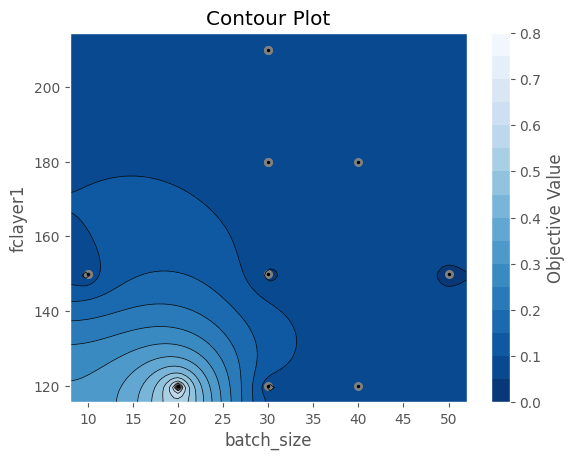

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:28,110] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


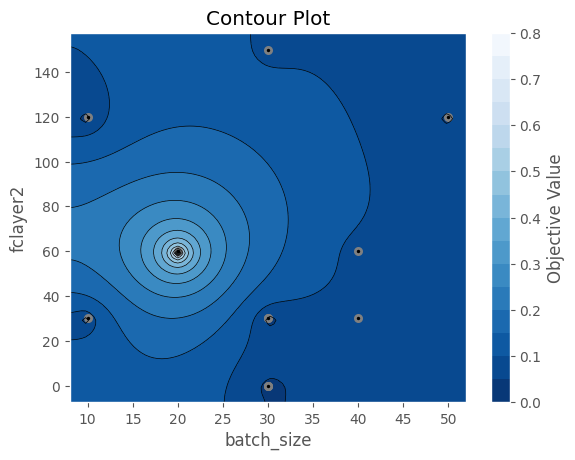

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:29,191] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


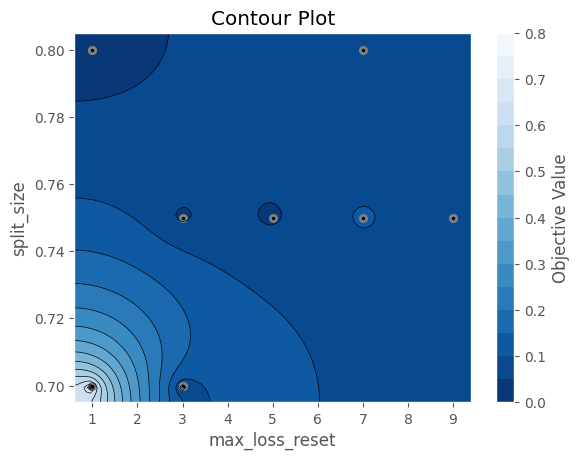

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:30,135] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


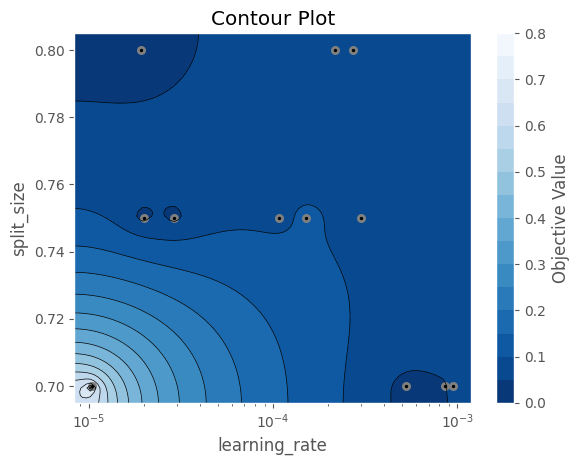

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:31,023] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


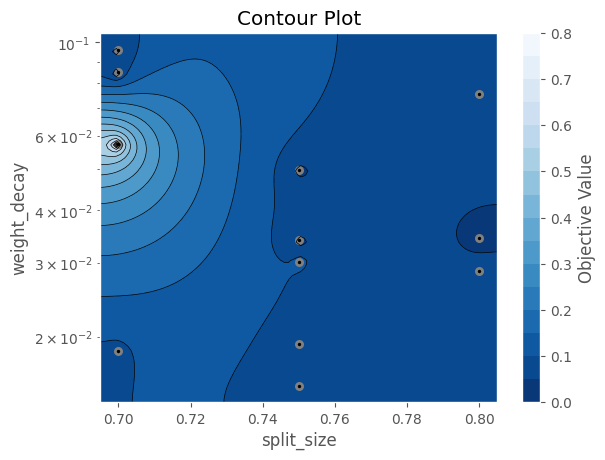

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:32,246] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


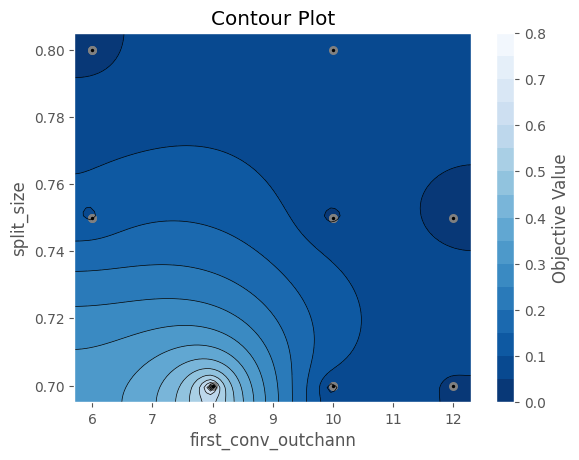

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:32,952] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


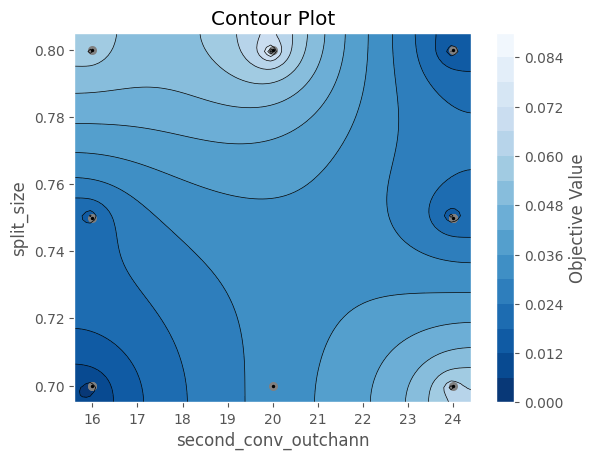

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:33,624] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


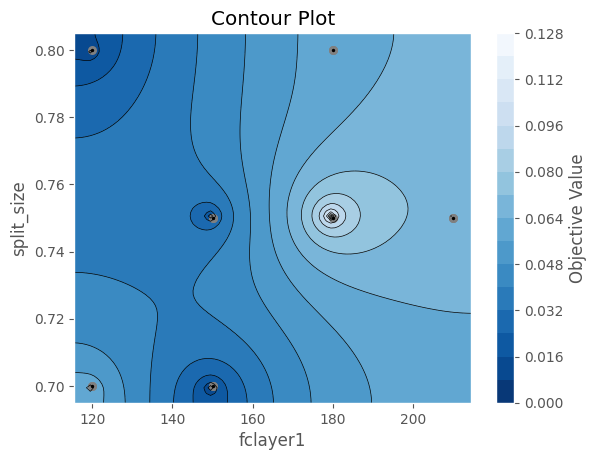

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:34,319] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


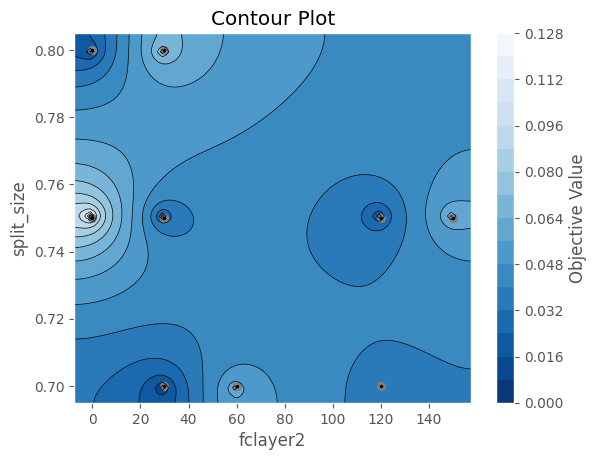

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:35,035] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


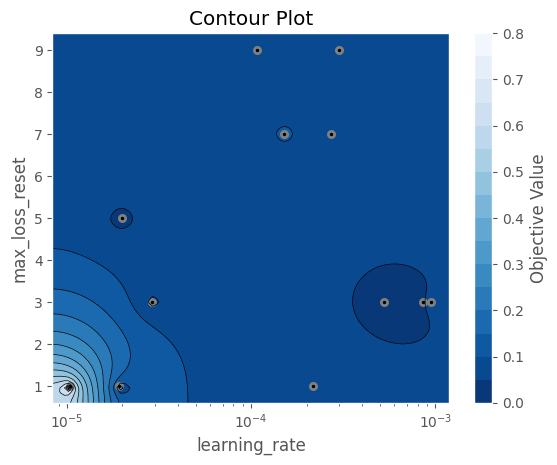

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:35,959] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


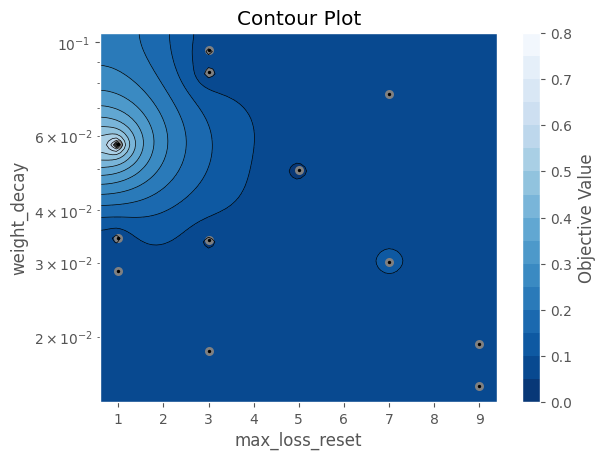

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:36,905] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


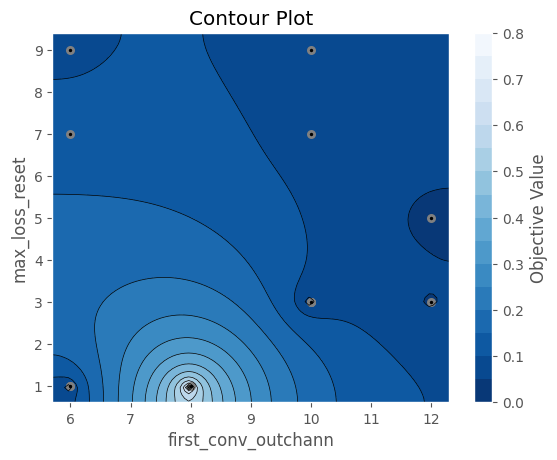

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:37,658] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


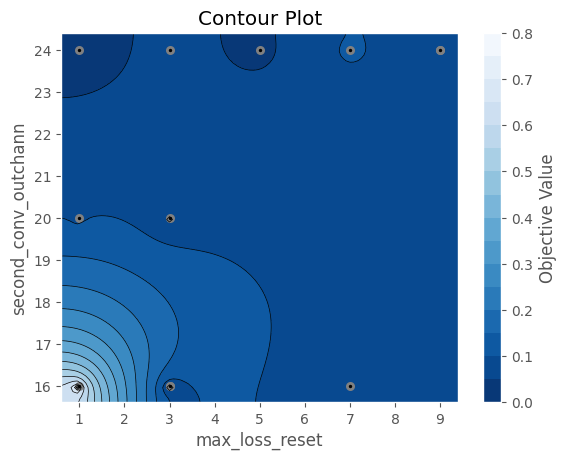

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:38,398] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


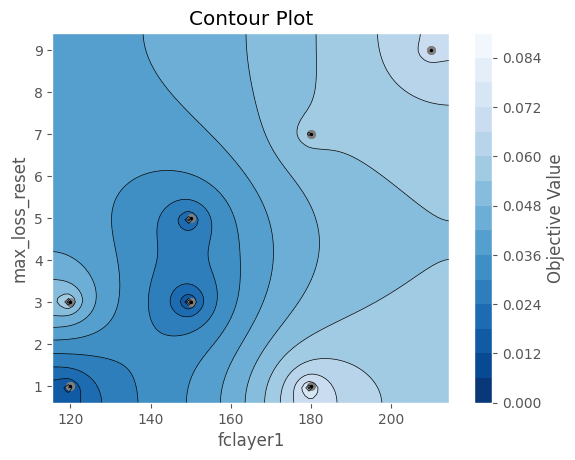

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:39,122] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


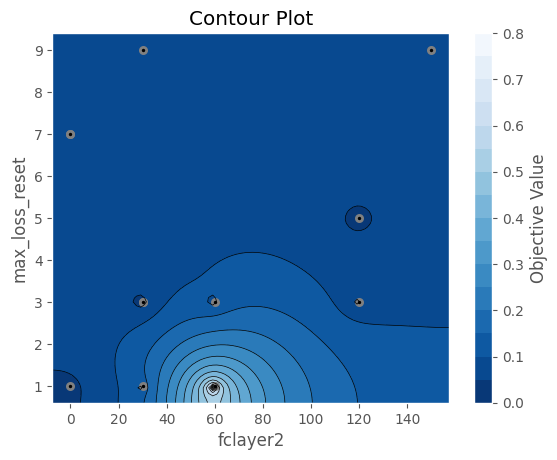

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:39,953] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


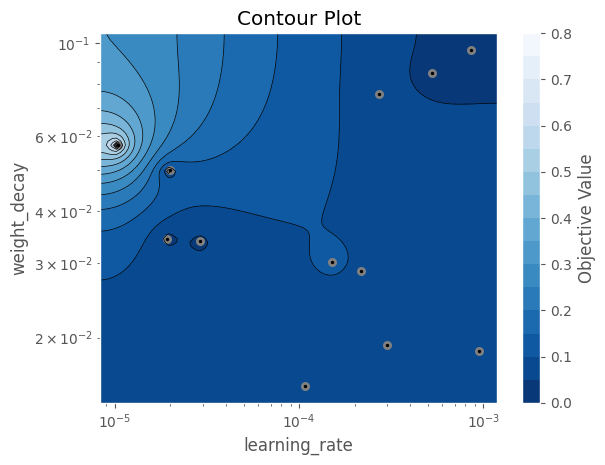

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:42,030] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


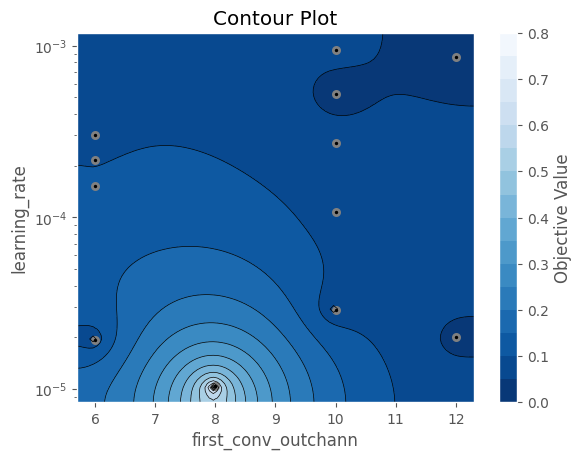

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:43,500] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


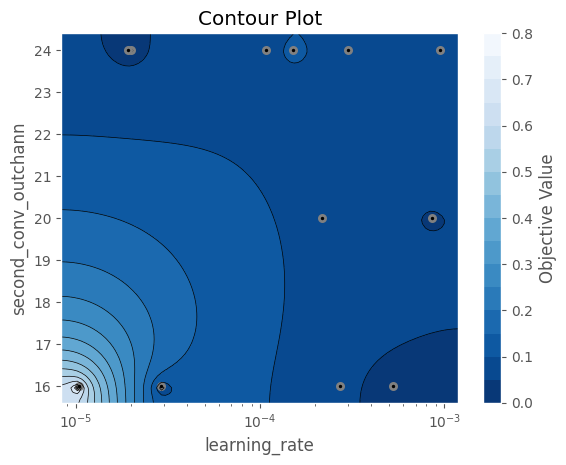

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:44,515] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


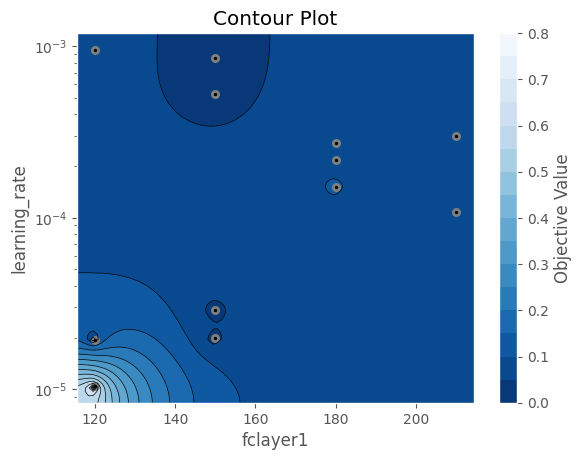

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:45,467] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


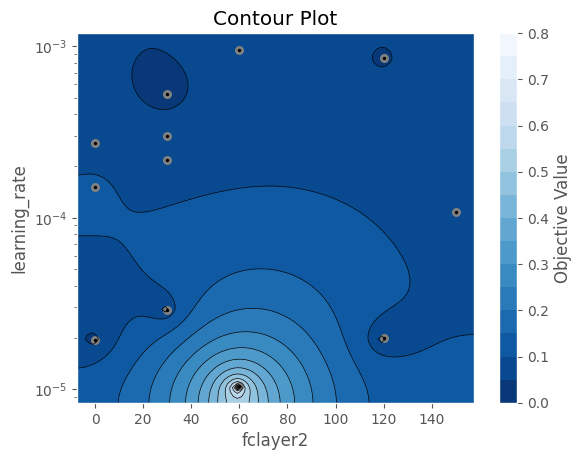

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:46,452] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


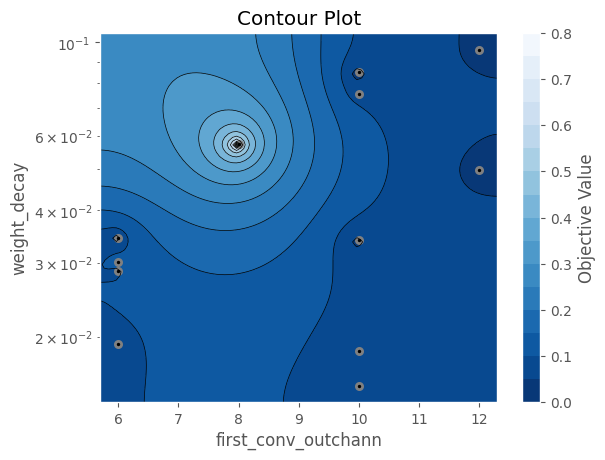

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:47,389] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


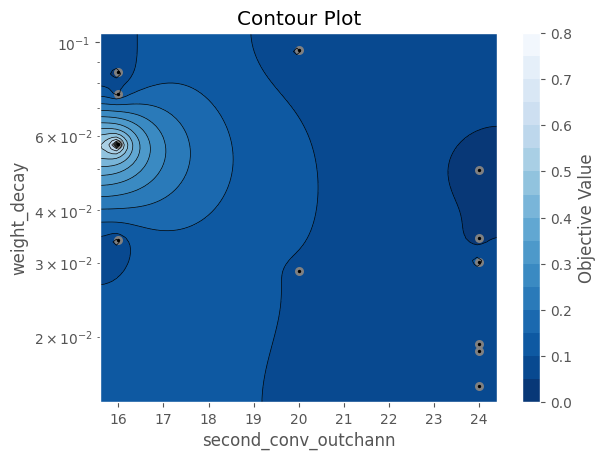

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:48,382] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


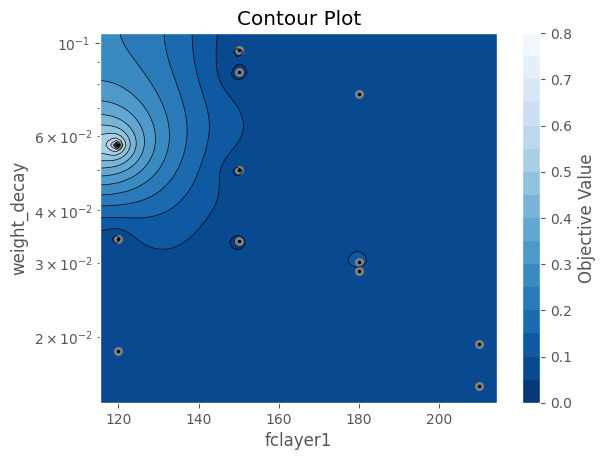

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:49,339] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


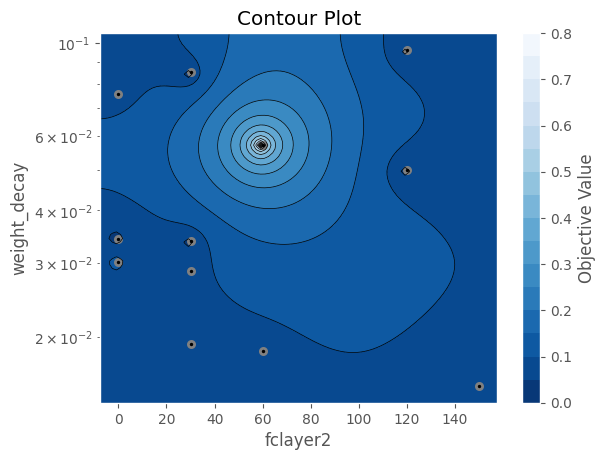

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:50,587] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


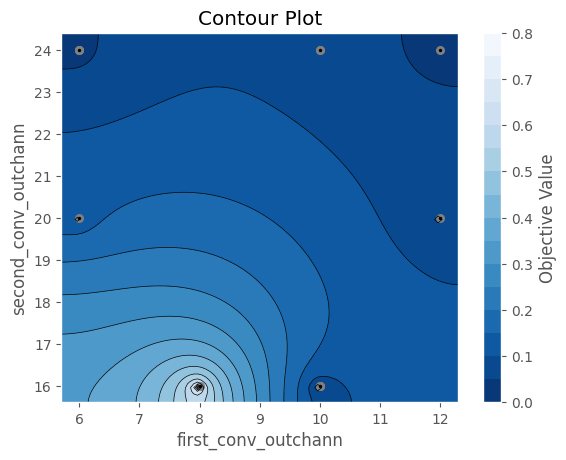

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:51,360] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


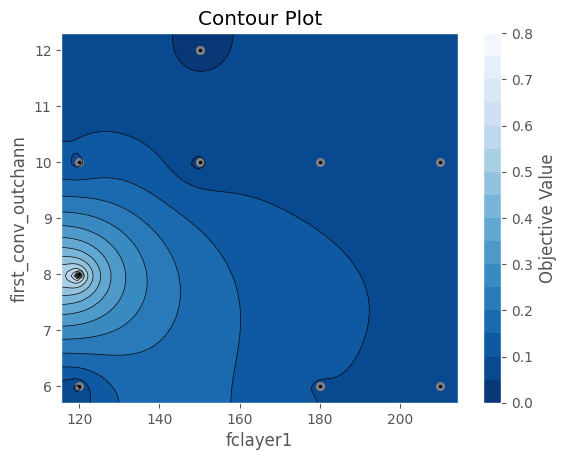

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:52,085] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


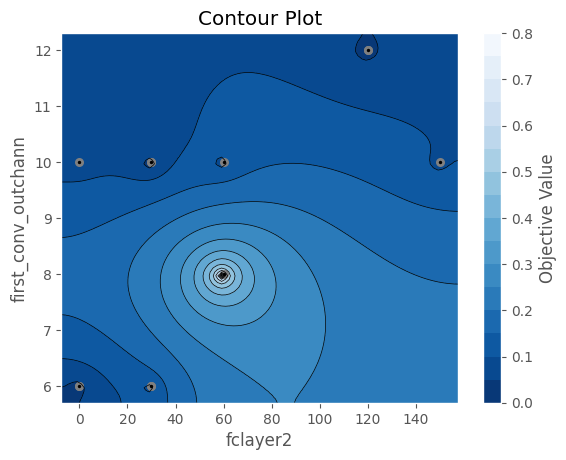

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:52,799] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


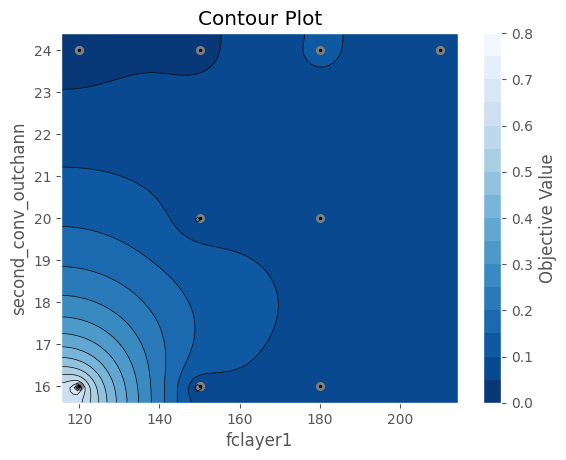

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:53,539] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


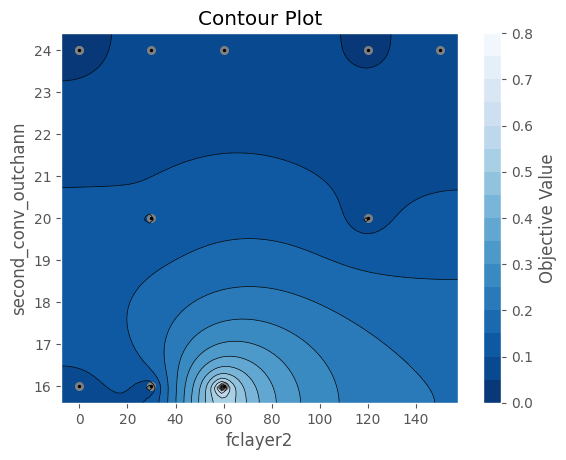

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:343: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_contour(study, params=[keys[i], keys[j]])
[W 2024-06-04 17:30:54,519] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


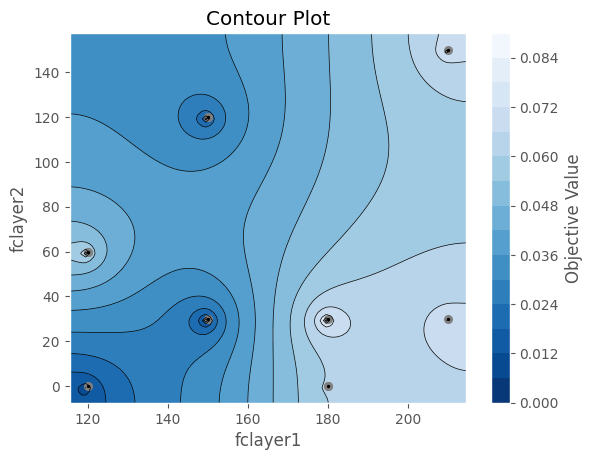

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:346: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig =  optuna.visualization.matplotlib.plot_contour(study )
[W 2024-06-04 17:30:55,417] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


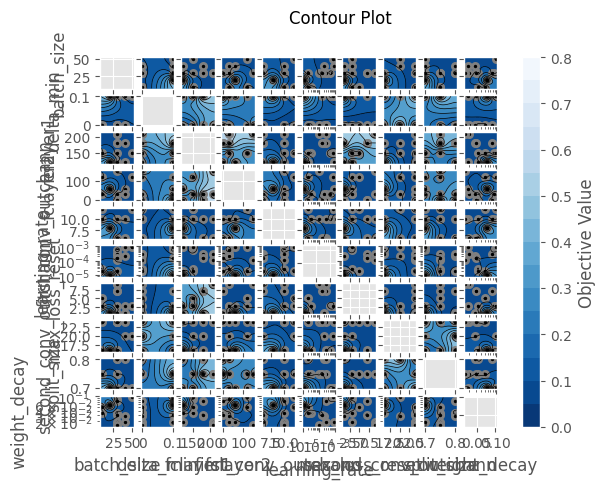

/content/Dementia_OASIS_Saturdays/hyperparameter_optimization.py:350: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_timeline(study)


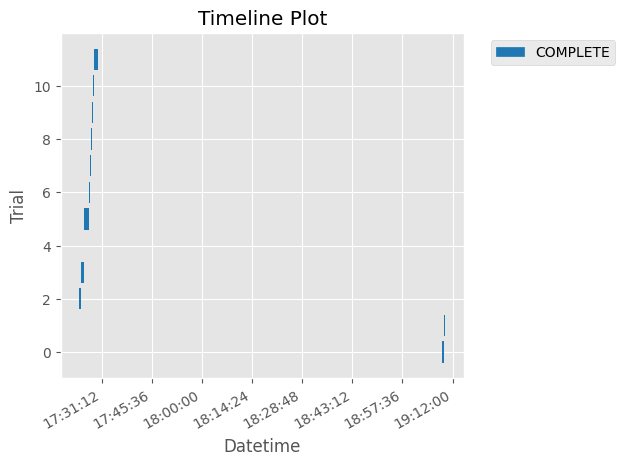

In [26]:
visualizeresults('studies/RAW_1.pbz2')


Entrenamos cada red neuronal con el tipo de imagenes que queramos y creamos los datasets

In [ ]:
# train(obj,'params/',['T88'])
# train(obj,'params/',['T88','FSL'])
train_nn(obj, 'params_nn/', ['T88', 'FSL', 'RAW_1', 'RAW_2', 'RAW_3'],logpath = logpath)

# getOutput('nn/',['T88'])
# getOutput('nn/',['T88','FSL'])
getOutput('nn/', ['T88', 'FSL', 'RAW_1', 'RAW_2', 'RAW_3'],device = device)


Ahora entrenamos el random_forest

In [ ]:

source_df = pd.read_csv('results.csv')
treeclass = Customtree(source_df)
#treeclass.write_dict_to_file('params_tree/treeparam.txt')
train_tree(treeclass,'params_tree/treeparam.txt')
